# Demographic Inference with Dadi, Moments, and MomentsLD

In [1]:
import os
import moments
from tqdm import tqdm
import numpy as np
import msprime
import dadi
import allel
import matplotlib.pylab as plt
import dadi.Demes
import glob
import demes
from Demographic_Inference.preprocess import delete_vcf_files, Simulator
from utils import visualizing_results, feature_importance, visualize_model_predictions, shap_values_plot, partial_dependence_plots
import re

ModuleNotFoundError: No module named 'Demographic_Inference'

In [7]:
# path_name = os.getcwd()

# os.chdir(os.path.join(path_name,'Simulation_Software'))

In [8]:
upper_bound_params = {'N0': 10000,
                      'Nb': 2000, 
                      'N_recover': 8000, 
                      't_bottleneck_end': 1000, 
                      't_bottleneck_start': 5000  # In generations            
                     }

lower_bound_params = {'N0': 8000, 
                      'Nb': 1000, 
                      'N_recover': 4000, 
                      't_bottleneck_end': 800, 
                      't_bottleneck_start': 2000 # In generations
                     }


num_simulations = 100
num_samples = 20

In [9]:
sim_obj = Simulator(upper_bound_params= upper_bound_params, lower_bound_params=lower_bound_params, num_sims = num_simulations, num_samples = num_samples, L = 1e8, recombination_rate=1e-8, mutation_rate=1e-8)

In [10]:
sample_params_storage = []
model_sfs = []

opt_params_dadi_list = []
model_sfs_dadi_list = []
opt_theta_dadi_list = []

opt_params_moments_list = []
model_sfs_moments_list = []
opt_theta_moments_list = []

for i in tqdm(np.arange(sim_obj.num_sims)):
    sampled_params = sim_obj.sample_params()
    sample_params_storage.append(sampled_params)

    # Need to create an SFS 
    sfs = sim_obj.create_SFS(sampled_params)
    model_sfs.append(sfs)
    
    opt_params_dadi, model_sfs_dadi, opt_theta_dadi = sim_obj.forward("dadi", sampled_params, sfs)
    opt_params_moments, model_sfs_moments, opt_theta_moments = sim_obj.forward("moments", sampled_params, sfs)

    opt_params_dadi_list.append(opt_params_dadi)
    model_sfs_dadi_list.append(model_sfs_dadi)
    opt_theta_dadi_list.append(opt_theta_dadi)

    opt_params_moments_list.append(opt_params_moments)
    model_sfs_moments_list.append(model_sfs_moments)
    opt_theta_moments_list.append(opt_theta_moments)


dadi_results = {
    'simulated_params': sample_params_storage,
    'opt_params': opt_params_dadi_list,
    'model_sfs': model_sfs_dadi_list,
    'opt_theta': opt_theta_dadi_list
}

moments_results = {
    'simulated_params': sample_params_storage,
    'opt_params': opt_params_moments_list,
    'model_sfs': model_sfs_moments_list,
    'opt_theta': opt_theta_moments_list
}

100%|██████████| 100/100 [02:49<00:00,  1.70s/it]


In [11]:
# momentsLD_results = sim_obj.forward("momentsLD")

In [13]:
# This code should be put in a different object/file later but for now just create a directory here for saved results. Later create an experiment manager. 
foldername = "results"
os.makedirs(foldername, exist_ok=True)

/results/inference_results_dadi.png


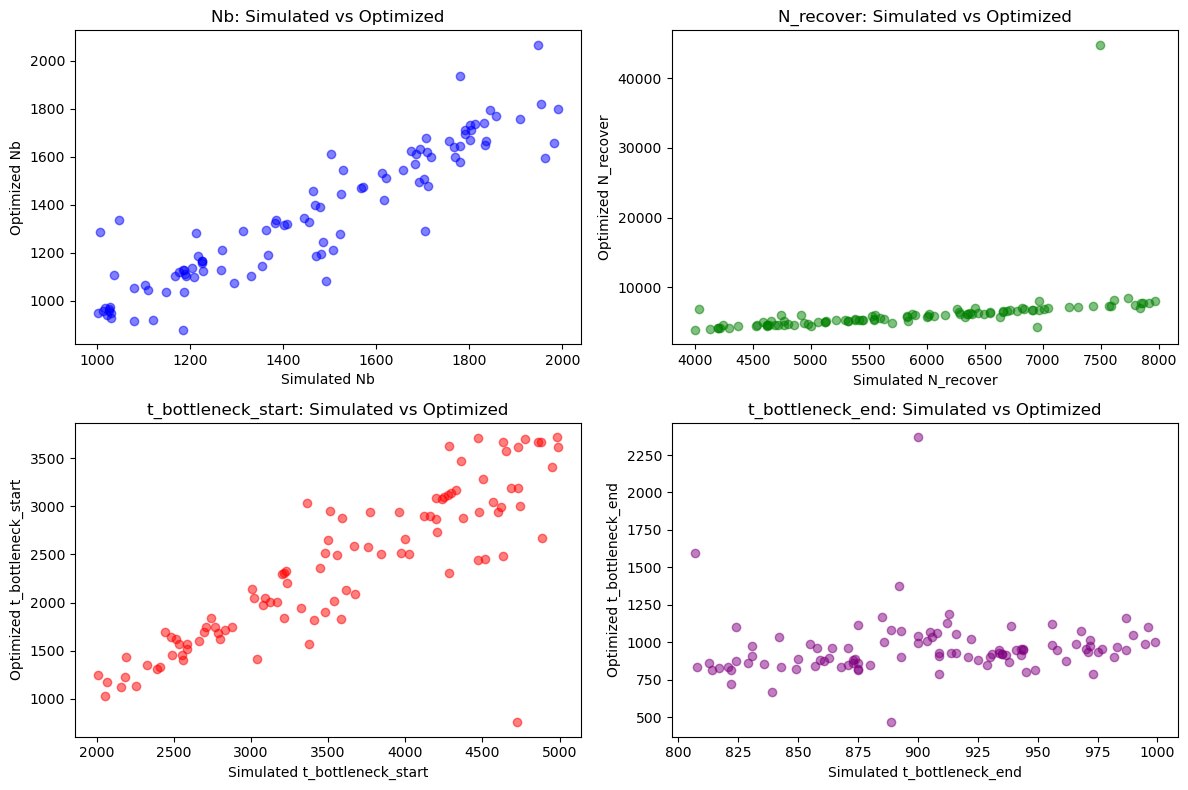

In [14]:
# I want to save the results as PNG files within the results folder 
visualizing_results(dadi_results, "dadi")

/results/inference_results_moments.png


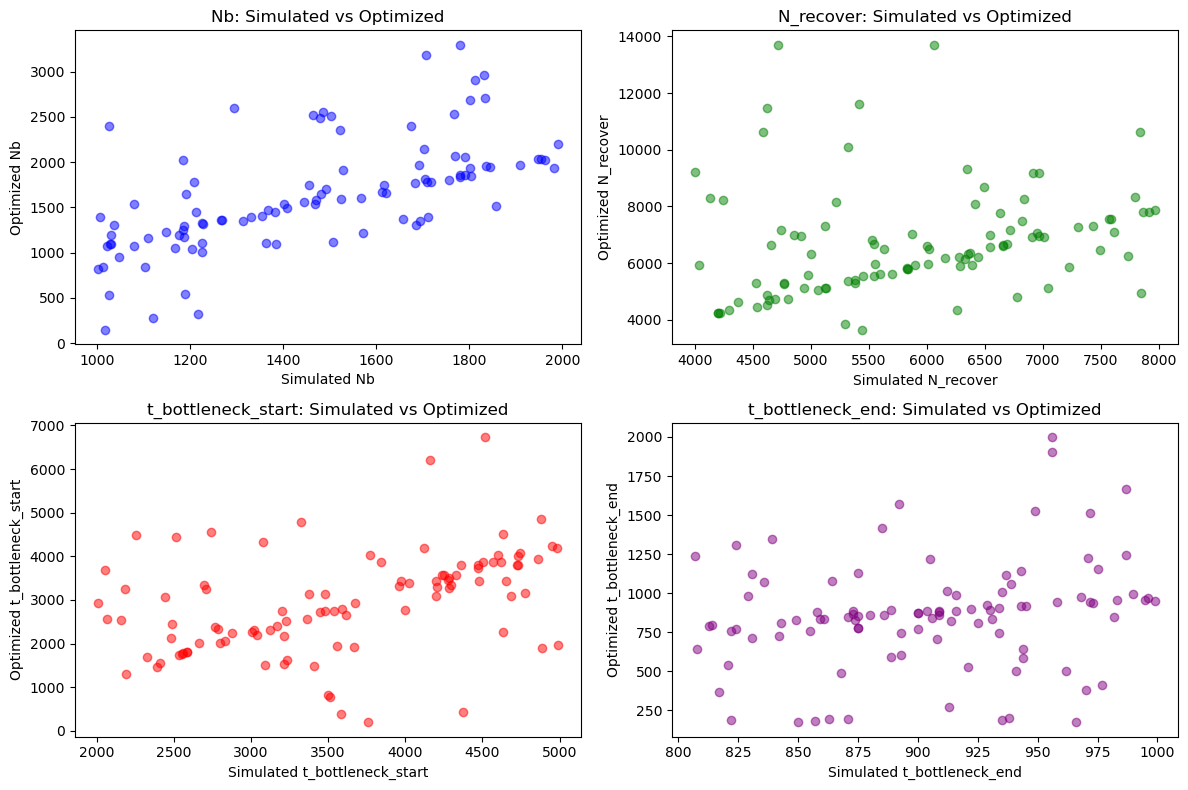

In [15]:
visualizing_results(moments_results, "moments")

## XGBoostin

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb


Define the features and targets

In [17]:
# Extract parameters from dadi_results

# Flattening the nested lists of dictionaries for dadi and moments results
opt_params_flat_dadi = [item for sublist in dadi_results['opt_params'] for item in sublist]
opt_params_flat_moments = [item for sublist in moments_results['opt_params'] for item in sublist]

sample_params_flat = [item for sublist in dadi_results['simulated_params'] for item in sublist]


# Extracting parameters from the flattened lists
Nb_opt_dadi = [d['Nb'] for d in opt_params_flat_dadi]
N_recover_opt_dadi = [d['N_recover'] for d in opt_params_flat_dadi]
t_bottleneck_start_opt_dadi = [d['t_bottleneck_start'] for d in opt_params_flat_dadi]
t_bottleneck_end_opt_dadi = [d['t_bottleneck_end'] for d in opt_params_flat_dadi]

Nb_opt_moments = [d['Nb'] for d in opt_params_flat_moments]
N_recover_opt_moments = [d['N_recover'] for d in opt_params_flat_moments]
t_bottleneck_start_opt_moments = [d['t_bottleneck_start'] for d in opt_params_flat_moments]
t_bottleneck_end_opt_moments = [d['t_bottleneck_end'] for d in opt_params_flat_moments]

Nb_sample = [d['Nb'] for d in dadi_results['simulated_params']]
N_recover_sample = [d['N_recover'] for d in dadi_results['simulated_params']]
t_bottleneck_start_sample = [d['t_bottleneck_start'] for d in dadi_results['simulated_params']] 
t_bottleneck_end_sample = [d['t_bottleneck_end'] for d in dadi_results['simulated_params']] 

# Combine the parameters into columns
Nb_opt = np.column_stack((Nb_opt_dadi, Nb_opt_moments))
N_recover_opt = np.column_stack((N_recover_opt_dadi, N_recover_opt_moments))
t_bottleneck_start_opt = np.column_stack((t_bottleneck_start_opt_dadi, t_bottleneck_start_opt_moments))
t_bottleneck_end_opt = np.column_stack((t_bottleneck_end_opt_dadi, t_bottleneck_end_opt_moments))

# Put all these features into a single 2D array
opt_params_array = np.column_stack((
    Nb_opt,
    N_recover_opt,
    t_bottleneck_start_opt,
    t_bottleneck_end_opt
))

# Combine simulated parameters into targets
targets = np.column_stack((Nb_sample, N_recover_sample, t_bottleneck_start_sample, t_bottleneck_end_sample))

# Features are the optimized parameters
features = opt_params_array

In [18]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=295)

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, verbosity = 2)

# Wrap the XGBoost model with MultiOutputRegressor
multi_output_model = MultiOutputRegressor(xgb_model)

# Train the model
multi_output_model.fit(X_train, y_train)

# Make predictions
y_pred = multi_output_model.predict(X_test)


In [19]:
# Evaluate the model

# Squared difference between prediction and true value, normalized by the true value
relative_squared_errors = ((y_pred - y_test) / y_test) ** 2

# Sum the relative squared errors across all columns and take the square root
sum_relative_squared_errors = np.sqrt(np.sum(relative_squared_errors, axis = 0))

print(f"Parameter-specific MSE: {sum_relative_squared_errors}")

Parameter-specific MSE: [0.35086876 0.46204083 0.25724191 0.2617232 ]


Now let's look at parameter-specific error before ML

In [20]:
# Dadi Error Results

# Calculate the relative squared errors for each column
relative_squared_errors = ((X_test[:,[0,2,4,6]] - y_test) / y_test) ** 2

# Sum the relative squared errors across all columns and take the square root
sum_relative_squared_errors = np.sqrt(np.sum(relative_squared_errors, axis = 0))
# result = np.sqrt(sum_relative_squared_errors)

print(f"Parameter-specific MSE: {sum_relative_squared_errors}")

Parameter-specific MSE: [0.56462966 0.4641603  1.60817755 0.73485655]


In [21]:
# Moments Error Results

# Calculate the relative squared errors for each column
relative_squared_errors = ((X_test[:,[1,3,5,7]] - y_test) / y_test) ** 2

# Sum the relative squared errors across all columns and take the square root
sum_relative_squared_errors = np.sqrt(np.sum(relative_squared_errors, axis = 0))
# result = np.sqrt(sum_relative_squared_errors)

print(f"Parameter-specific MSE: {sum_relative_squared_errors}")

Parameter-specific MSE: [1.85303659 1.70538687 2.063705   1.96826185]


### Interpretability

In [22]:
# Feature names dictionary
feature_names = {
    0: 'Nb_opt_dadi',
    1: 'Nb_opt_moments',
    2: 'N_recover_opt_dadi',
    3: 'N_recover_opt_moments',
    4: 't_bottleneck_start_opt_dadi',
    5: 't_bottleneck_start_opt_moments',
    6: 't_bottleneck_end_opt_dadi',
    7: 't_bottleneck_end_opt_moments'
}


target_names = {
    0: 'Nb_sample',
    1: 'N_recover_sample',
    2: 't_bottleneck_start_sample',
    3: 't_bottleneck_end_sample'
}

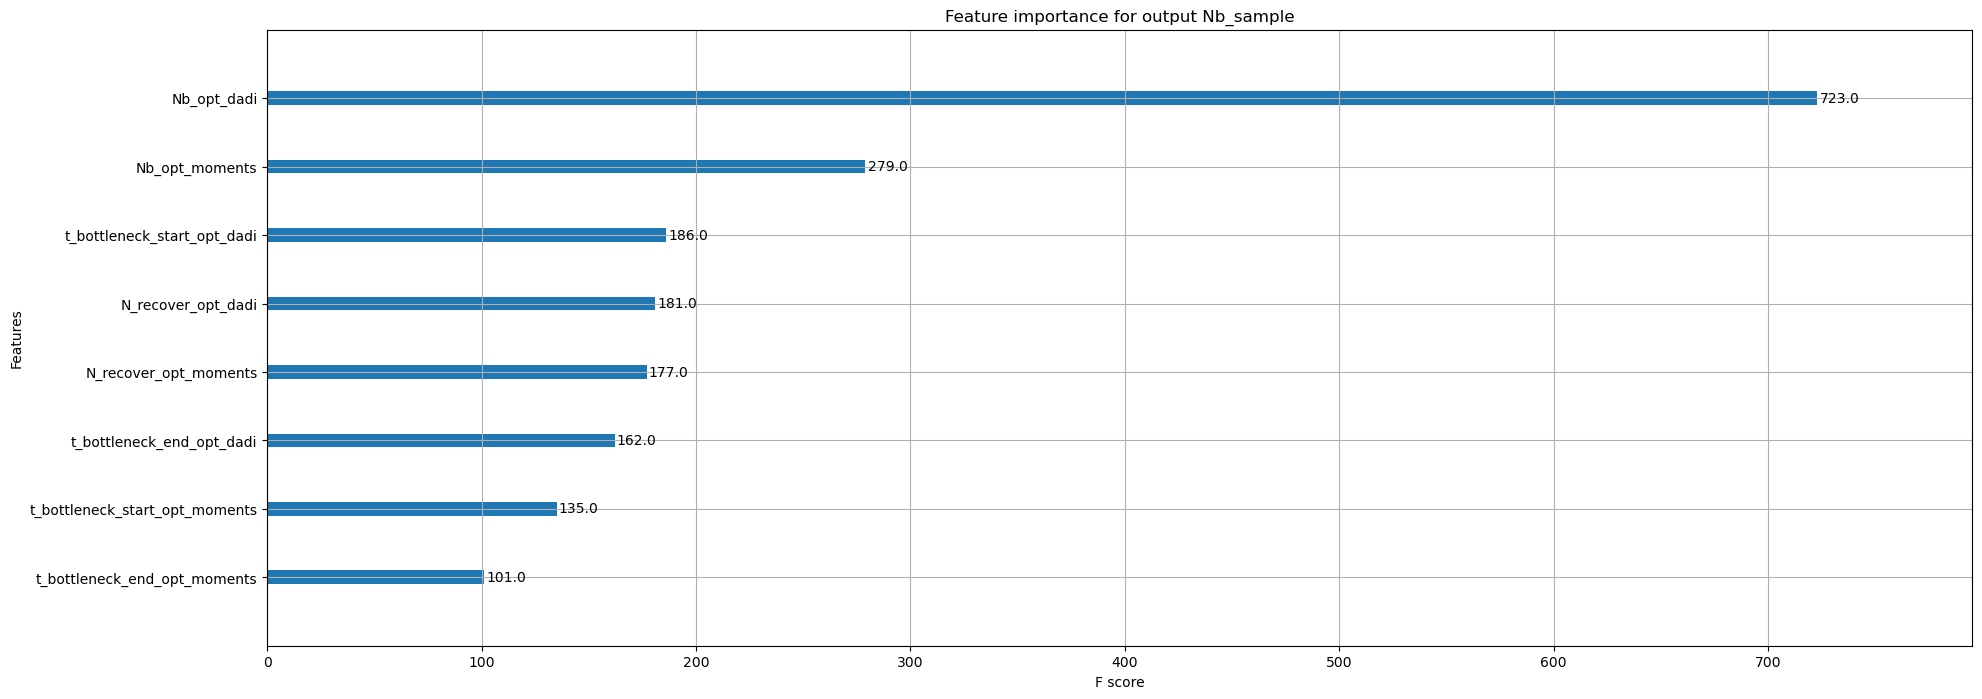

In [23]:
feature_importance(multi_output_model=multi_output_model, model_number=0, feature_names=feature_names, target_names=target_names)

Basically this is the feature importance plot for the XGB model predicting the Bottleneck size. We see that dadi's inference for the bottleneck size is the best predictor for the actual bottleneck size

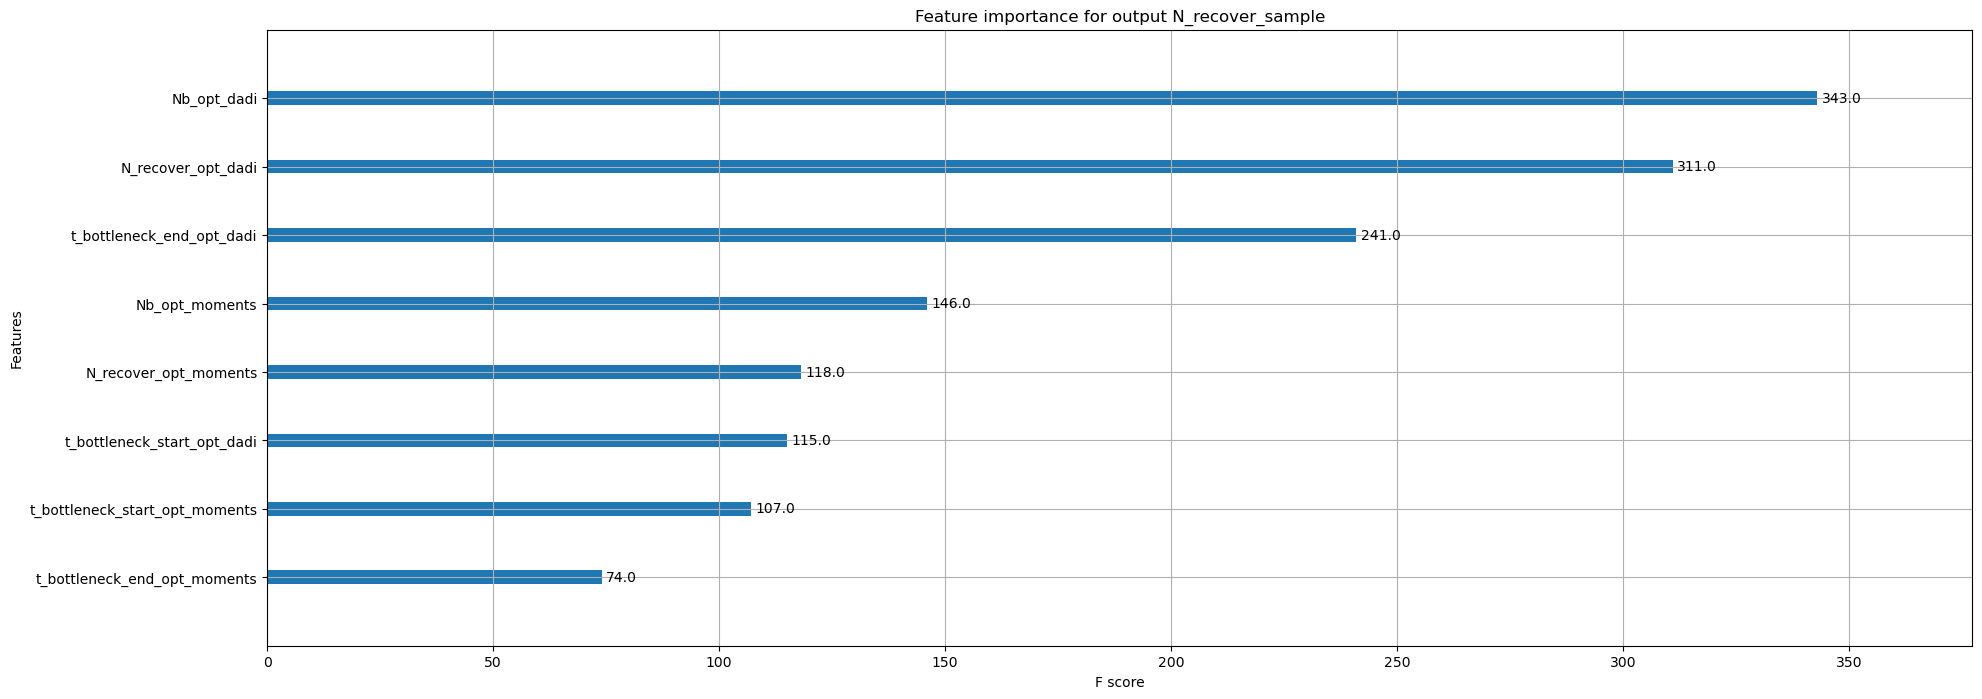

In [24]:
feature_importance(multi_output_model=multi_output_model, model_number=1, feature_names=feature_names, target_names=target_names)

Dadi's estimate of the recovery population size is the best predictor for the actual recovery population size

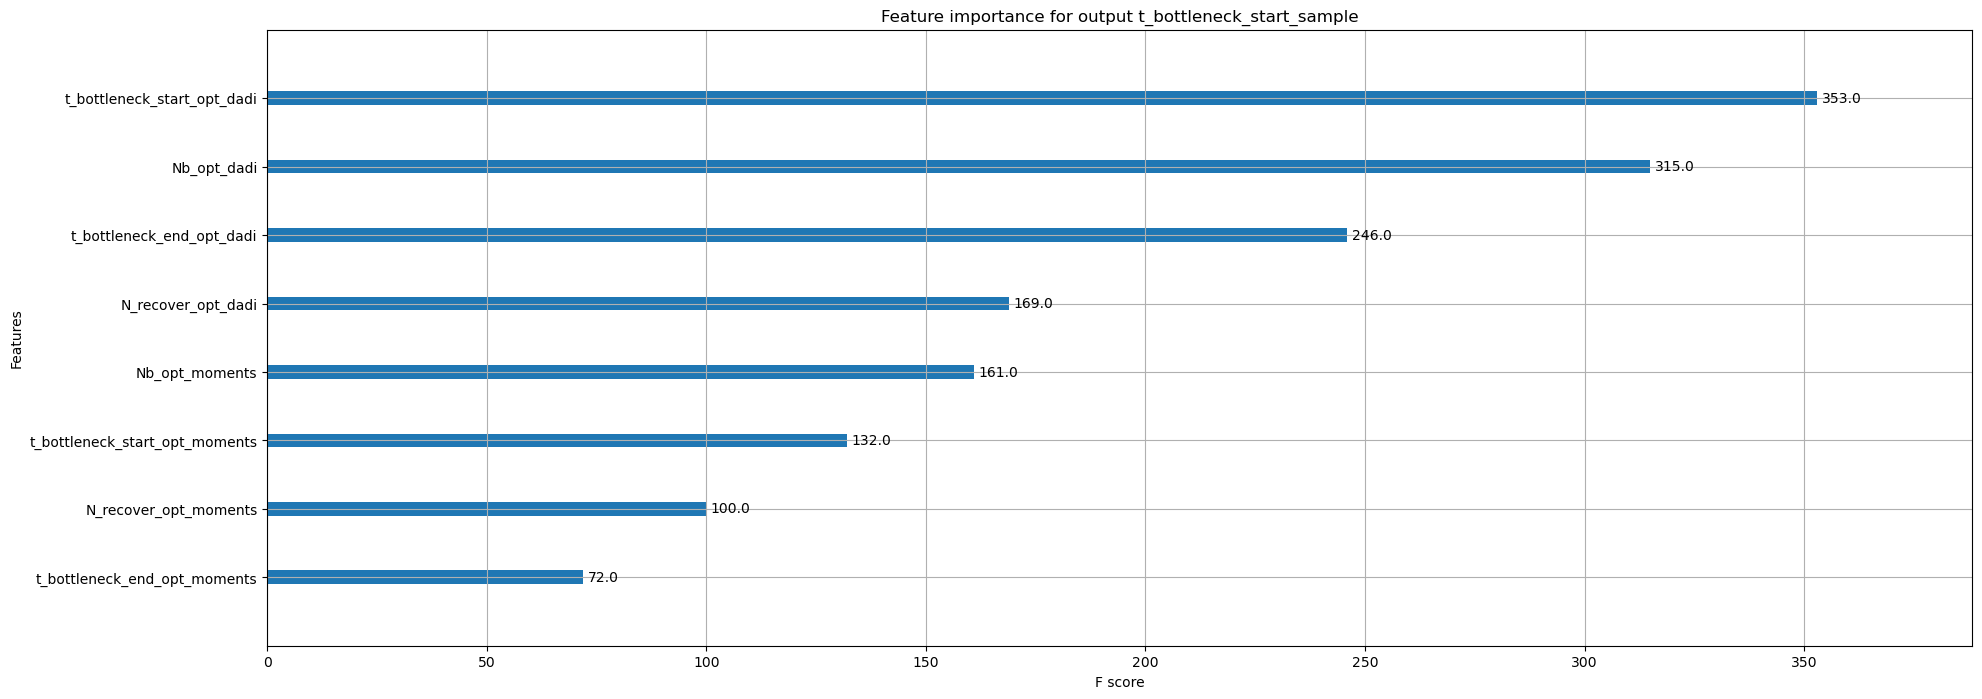

In [25]:
feature_importance(multi_output_model=multi_output_model, model_number=2, feature_names=feature_names, target_names=target_names)

Dadi's estimate of the bottleneck size is the best predictor for the time in the bottleneck. This is closely followed up by dadi's estimate of the time inside the bottlneck. 

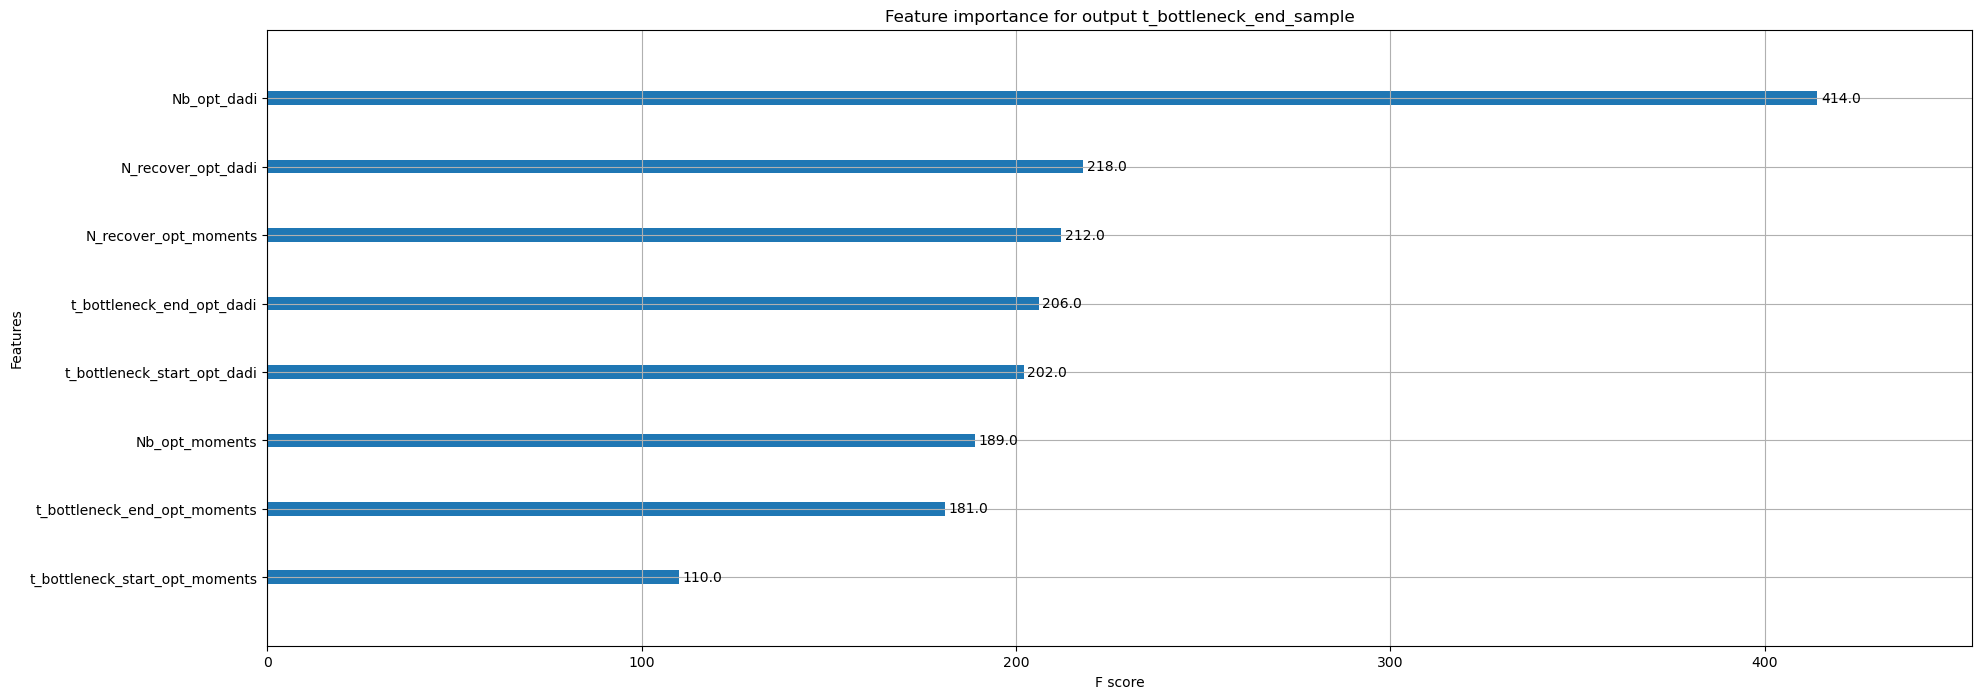

In [26]:
feature_importance(multi_output_model=multi_output_model, model_number=3, feature_names=feature_names, target_names=target_names)

This is a bit weird. Dadi's estimate of the bottleneck size is the best predictor of the recovery time after the bottleneck.

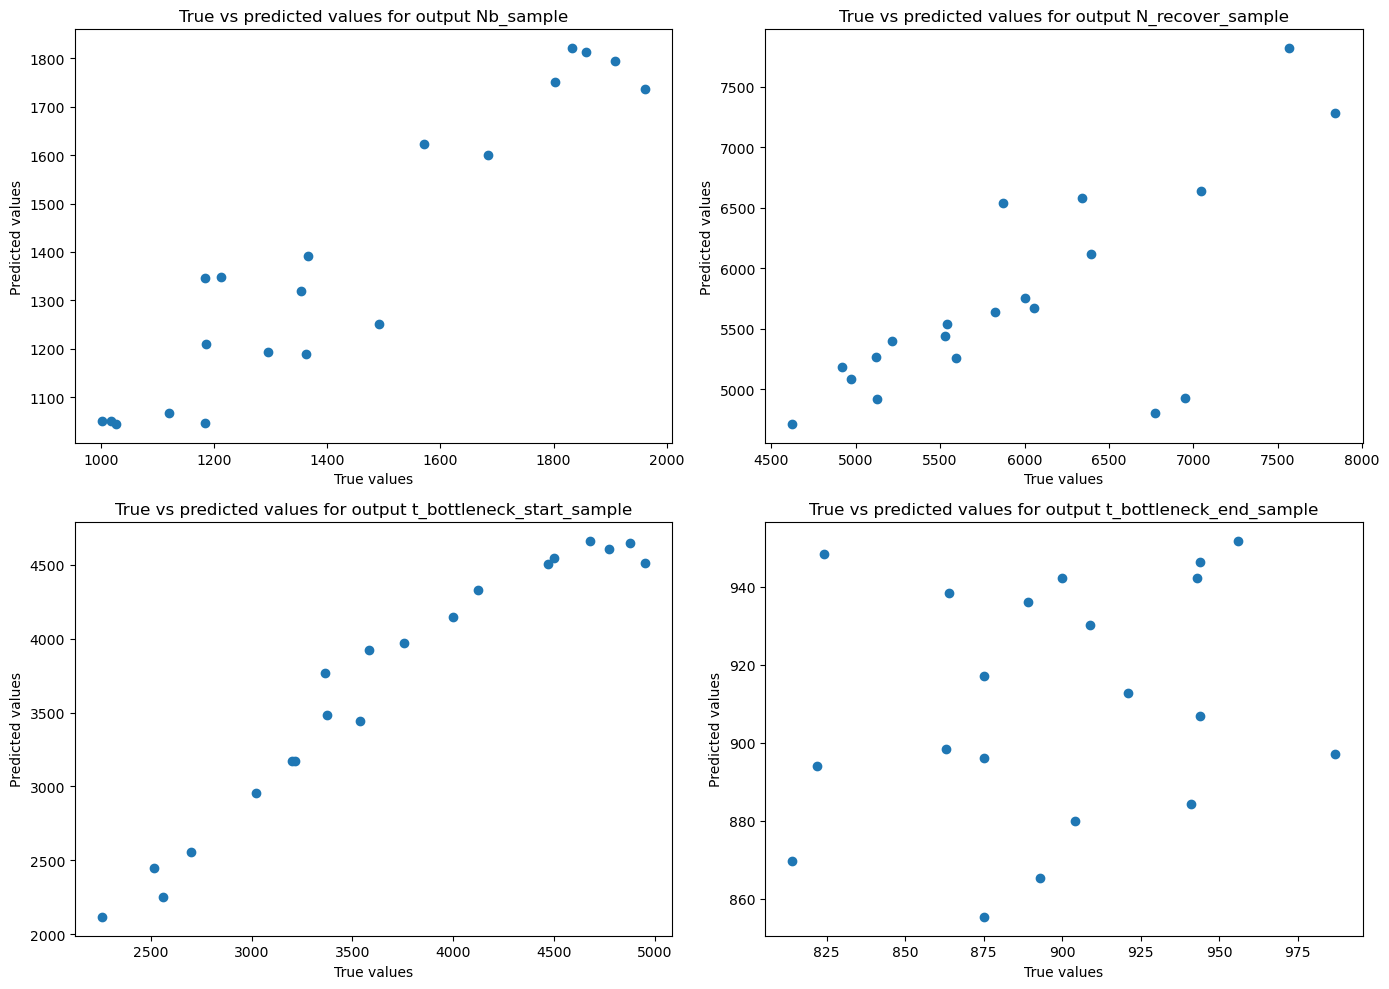

Figure saved to results/model_predictions.png


In [27]:
visualize_model_predictions(y_test, y_pred, target_names=target_names)

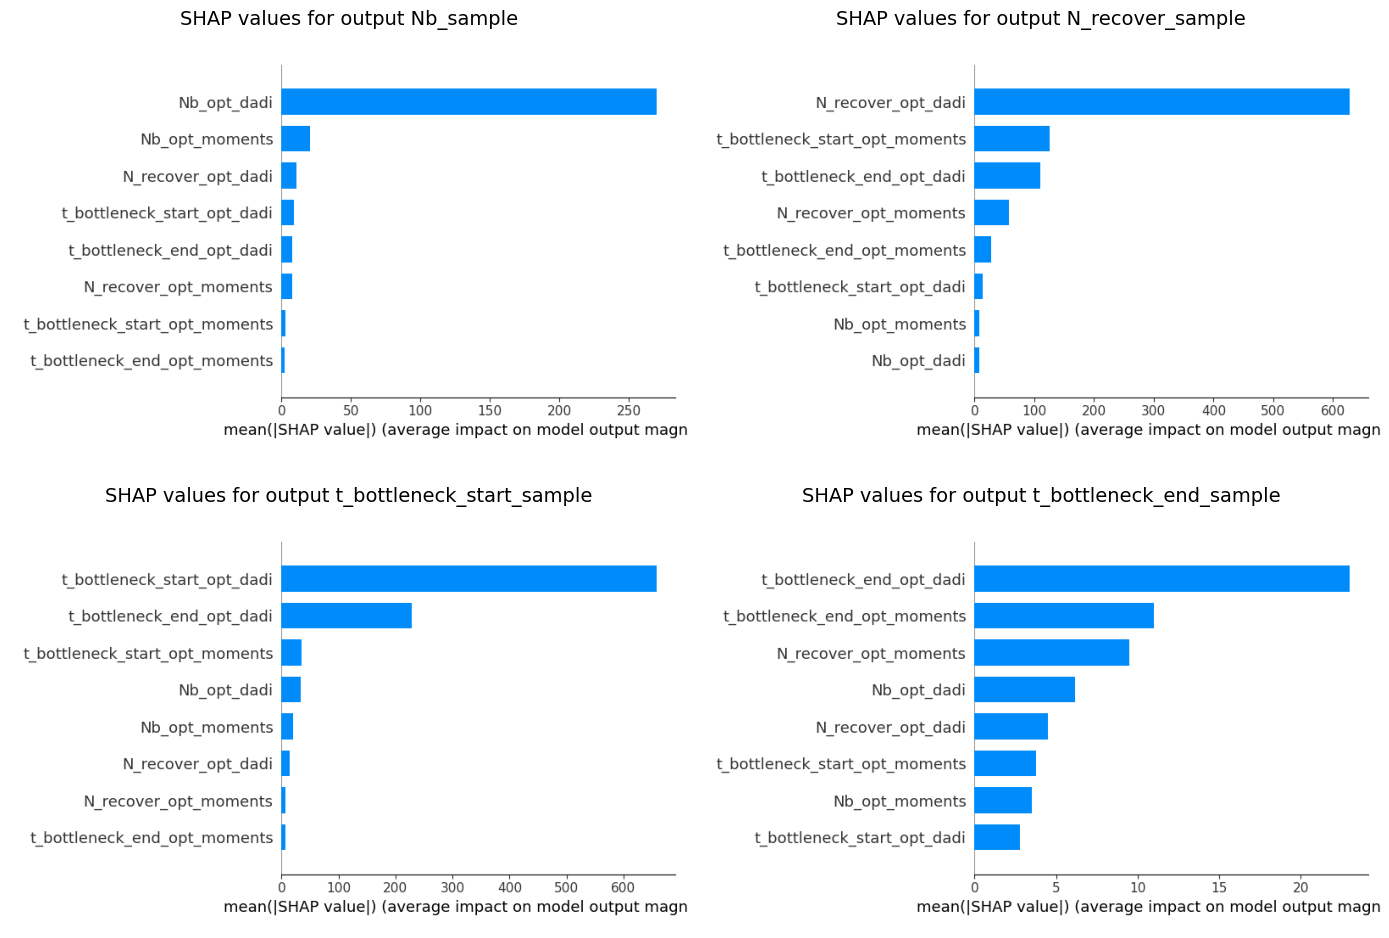

Figure saved to results/shap_values.png


In [28]:
shap_values_plot(X_test, multi_output_model=multi_output_model, feature_names=feature_names, target_names=target_names)

The figure layout has changed to tight

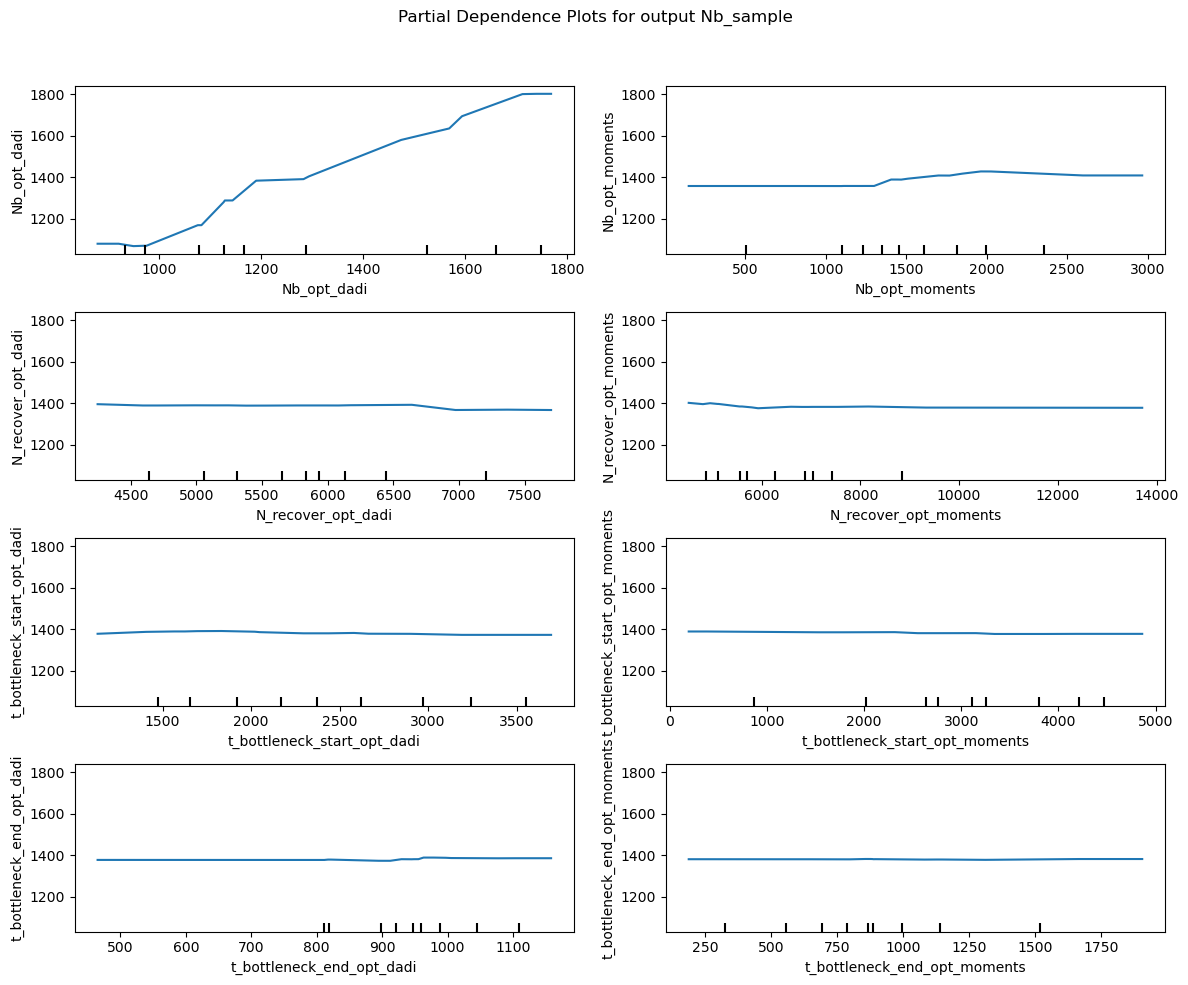

In [29]:
partial_dependence_plots(multi_output_model, X_test, 0, [0, 1, 2, 3, 4, 5, 6, 7], feature_names, target_names)

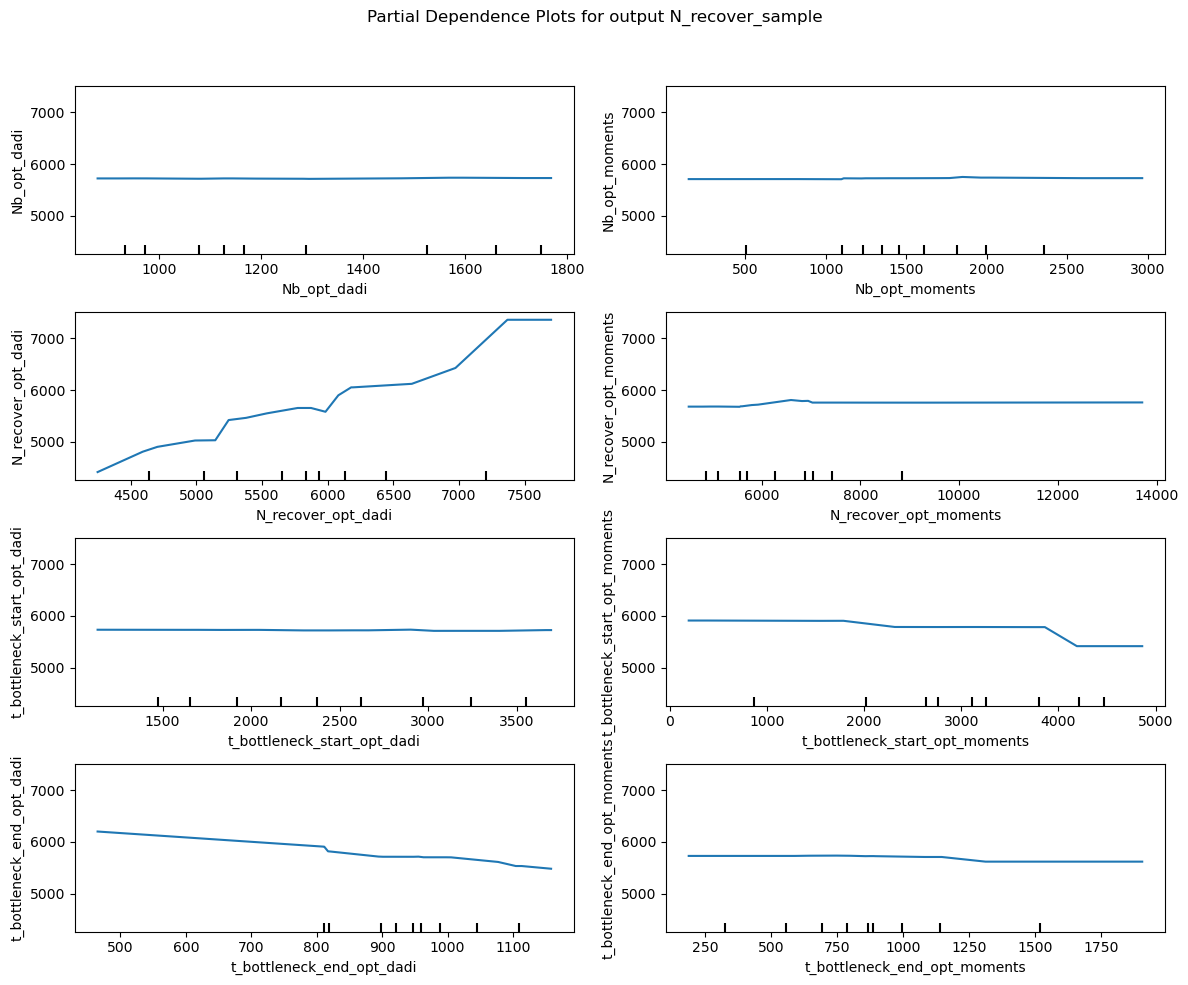

In [30]:
partial_dependence_plots(multi_output_model, X_test, 1, [0, 1, 2, 3, 4, 5, 6, 7], feature_names, target_names)

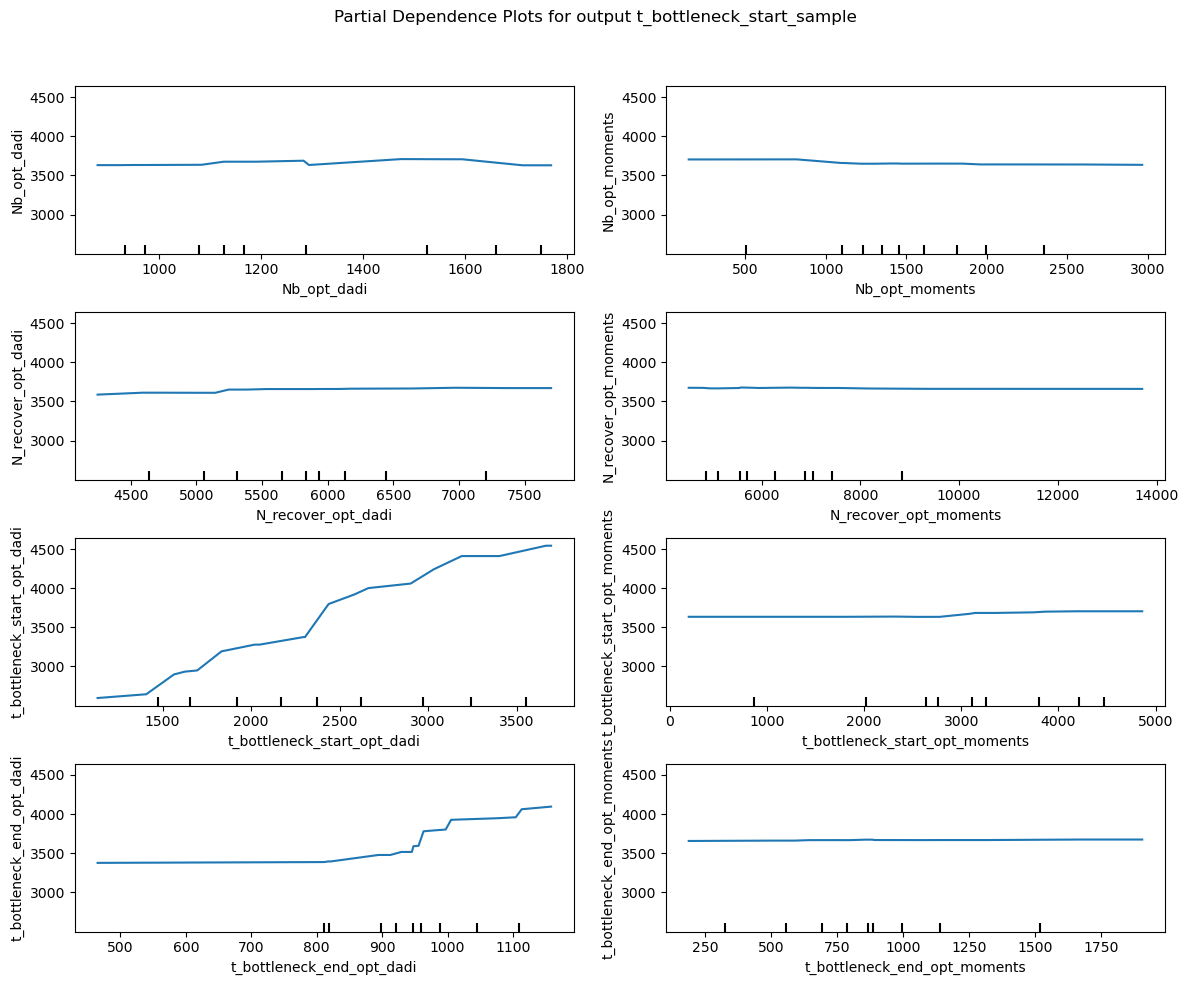

In [31]:
partial_dependence_plots(multi_output_model, X_test, 2, [0, 1, 2, 3, 4, 5, 6, 7], feature_names, target_names)

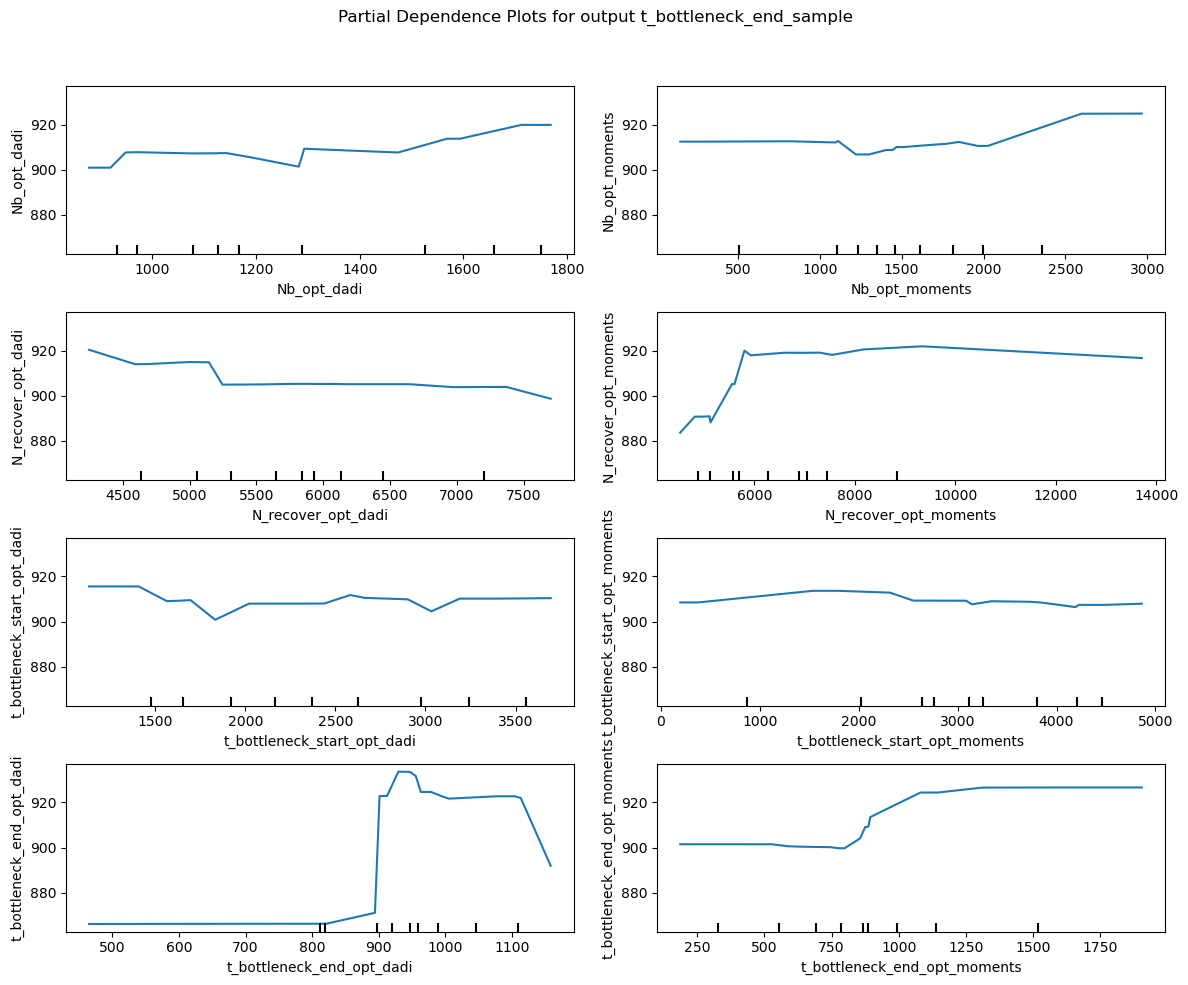

In [32]:
partial_dependence_plots(multi_output_model, X_test, 3, [0, 1, 2, 3, 4, 5, 6, 7], feature_names, target_names)

In [ ]:
# Residual plot for the first output
residuals = y_test[:, 0] - y_pred[:, 0]
plt.scatter(y_pred[:, 0], residuals)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted for output 1')
plt.axhline(0, color='red', linestyle='--')
plt.show()